/home/joaobiu/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


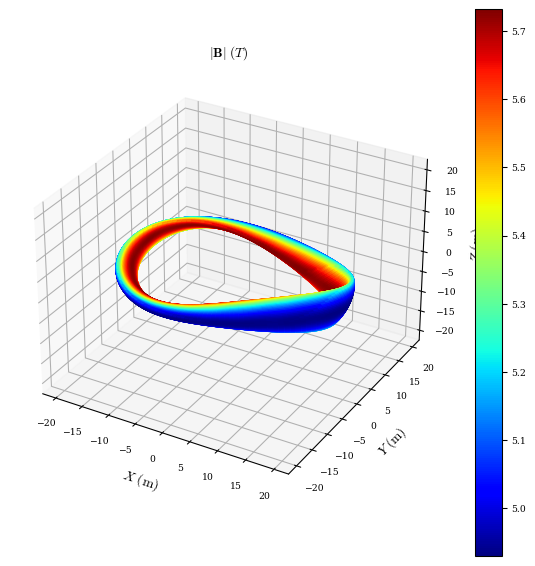

In [9]:
from desc.compute.utils import get_transforms, get_profiles, get_params, dot, cross
from desc.compute import compute as compute_fun
from desc.backend import jnp
from desc.grid import Grid
import desc.io
import desc.examples
from functools import partial
from jax import jit
from jax.experimental.ode import odeint as jax_odeint
import matplotlib.pyplot as plt
import numpy as np
from desc.equilibrium import Equilibrium
from desc.plotting import plot_surfaces, plot_3d

eq = desc.io.load("/home/joaobiu/DESC/desc/examples/test_run.h5")
eq._iota = eq.get_profile("iota")
eq._current = None 

#plot_3d(eq, "|B|")


def rhs(w, t, a):
    
    #initial conditions
    psi, theta, zeta, vpar = w
    
    E = a[0]

    #obtaining data from DESC   
    keys = ["B", "|B|", "grad(|B|)", "grad(psi)", "e^theta", "e^zeta", "G"] # etc etc, whatever terms you need
    grid = Grid(jnp.array([psi, theta, zeta]).T, jitable=True, sort=False)
    transforms = get_transforms(keys, eq, grid, jitable=True)
    profiles = get_profiles(keys, eq, grid, jitable=True)
    params = get_params(keys, eq)
    data = compute_fun(eq, keys, params, transforms, profiles)
    
    mu = E/(data["|B|"]) - (vpar**2)/(4*data["|B|"])
    
    psidot = a[1]*(1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["grad(psi)"]) # etc etc
    
    
    thetadot = a[2]*vpar/data["|B|"] * jnp.sum(data["B"] * data["e^theta"]) + a[1]*(1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["e^theta"])
    
    
    zetadot = a[3]*(vpar/data["|B|"]) * dot(data["B"], data["e^zeta"]) 
    
    b = data["B"]/data["|B|"]

    teste1 = (b + (1/(vpar*data["|B|"]**3)) * (mu*data["|B|"] + vpar**2) * jnp.cross(data["B"], data["grad(|B|)"], axis=-1))
    teste2 = data["grad(|B|)"]
    vpardot = -mu*dot(teste1,teste2)
    #vpardot = -mu*jnp.sum(((data["B"]/data["|B|"])+ (1/vpar*data["|B|"]**3)*(mu*data["|B|"] + vpar**2)*jnp.cross(data["B"], data["grad(|B|)"], axis=-1)) * data["grad(|B|)"])
    
    return jnp.array([psidot, thetadot, zetadot, vpardot]) #, zetadot, vpardot])


In [6]:
e_charge = 1.6e-19
E = 3.52e4
v_parallel = 0.8*jnp.sqrt(E/8)

a_initial = [E, 2, 1, 1]
initial_conditions = [0.2, 0.2, 0.1, v_parallel]

In [7]:
nt_per_time_unit = 10
tmin = 0
tmax = 10
nt = int(nt_per_time_unit * (tmax - tmin))

def solve_with_jax(a=None):
    initial_conditions_jax = jnp.array(initial_conditions, dtype=jnp.float64)
    if a is not None:
        a_jax = a
    else:
        a_jax = jnp.array(a_initial, dtype=jnp.float64)
    t_jax = jnp.linspace(tmin, tmax, nt)
    system_jit = jit(rhs)
    #solution_jax = jax_odeint(system_jit, initial_conditions_jax, t_jax, a_jax)
    solution_jax = jax_odeint(partial(system_jit, a=a_jax), initial_conditions_jax, t_jax)
    return solution_jax

In [4]:
sol = solve_with_jax()

print(sol)

2023-08-30 12:11:04.998477: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


[[2.00000000e-01 2.00000000e-01 1.00000000e-01 2.12263987e-08]
 [2.00000000e-01 2.00000000e-01 1.00000000e-01 2.12263987e-08]
 [2.00000000e-01 2.00000000e-01 1.00000000e-01 2.12263987e-08]
 [2.00000000e-01 2.00000000e-01 1.00000000e-01 2.12263987e-08]
 [2.00000000e-01 2.00000000e-01 1.00000000e-01 2.12263987e-08]
 [2.00000000e-01 2.00000000e-01 1.00000001e-01 2.12263987e-08]
 [2.00000000e-01 2.00000000e-01 1.00000001e-01 2.12263987e-08]
 [2.00000000e-01 2.00000001e-01 1.00000001e-01 2.12263987e-08]
 [2.00000000e-01 2.00000001e-01 1.00000001e-01 2.12263987e-08]
 [2.00000000e-01 2.00000001e-01 1.00000001e-01 2.12263987e-08]
 [2.00000000e-01 2.00000001e-01 1.00000001e-01 2.12263987e-08]
 [2.00000000e-01 2.00000001e-01 1.00000001e-01 2.12263987e-08]
 [2.00000000e-01 2.00000001e-01 1.00000001e-01 2.12263987e-08]
 [2.00000000e-01 2.00000001e-01 1.00000001e-01 2.12263987e-08]
 [2.00000000e-01 2.00000001e-01 1.00000002e-01 2.12263987e-08]
 [2.00000000e-01 2.00000001e-01 1.00000002e-01 2.122639

2023-08-30 12:12:48.731548: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m43.73292521s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


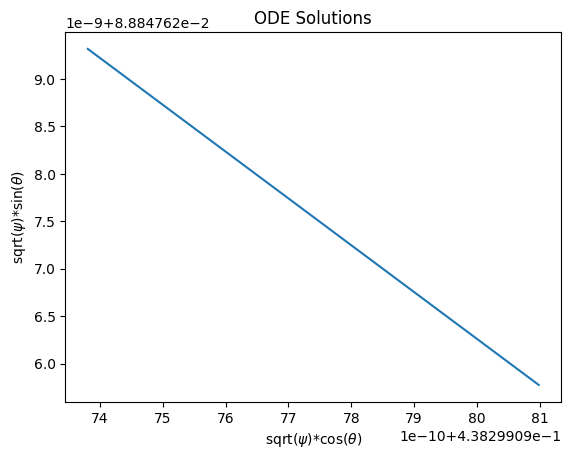

In [5]:
plt.plot(np.sqrt(sol[1:, 0]) * np.cos(sol[1:, 1]), np.sqrt(sol[1:, 0]) * np.sin(sol[1:, 1]))
plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.title('ODE Solutions')
plt.show()